In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#Find out the columns in each table
inspector = inspect(engine)

m_columns=inspector.get_columns('measurement')
s_columns= inspector.get_columns('station')
print("Columns in measurement:")
for c in m_columns:
    print(f"{c['name']}: {c['type']}")
    
print("\nColumns in Station:")
for c in s_columns:
    print(f"{c['name']}: {c['type']}")

Columns in measurement:
id: INTEGER
station: TEXT
date: TEXT
prcp: FLOAT
tobs: FLOAT

Columns in Station:
id: INTEGER
station: TEXT
name: TEXT
latitude: FLOAT
longitude: FLOAT
elevation: FLOAT


# Exploratory Climate Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [11]:
#Query last date in database
last_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).\
            first().date
last_date=dt.datetime.strptime(last_date, "%Y-%m-%d")
print(last_date)

2017-08-23 00:00:00


In [12]:
# Calculate the date 1 year ago from the last data point in the database
query_date = (last_date - dt.timedelta(days=365)).strftime("%Y-%m-%d")
print(query_date)
# Perform a query to retrieve the data and precipitation scores
query_data=session.query(Measurement.date,Measurement.prcp).\
            filter(Measurement.date >= query_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
data_df = pd.DataFrame(query_data, columns=['date','precp'])

# Sort the dataframe by date
data_df= data_df.sort_values(by=['date'])
data_df.head()

data_df.dropna(inplace=True)

2016-08-23


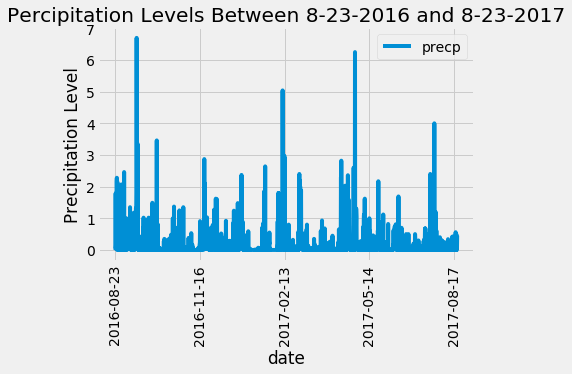

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
data_df.plot('date','precp',rot=90)
plt.title("Percipitation Levels Between 8-23-2016 and 8-23-2017")
plt.ylabel("Precipitation Level")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df.describe()

,precp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
num_station=session.query(func.count(Station.id)).all()
num_station

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station= session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station, func.min(Measurement.tobs),\
              func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station=="USC00519281").all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
station_data=session.query(Measurement.station, Measurement.tobs).\
            filter(Measurement.station=="USC00519281").\
            filter(Measurement.date>=query_date).all()

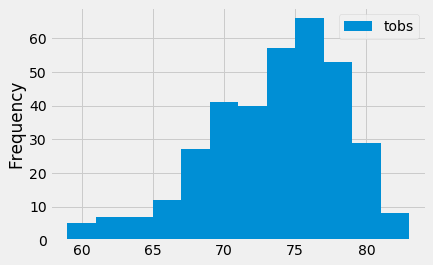

In [19]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_df=pd.DataFrame(station_data)
station_df.plot(kind="hist",bins=12)

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#If I understand I should pick a week of time to go to Hawii I'll use 10/17 to 10/24
results=calc_temps('2016-10-17','2016-10-24')[0]
print(results)

(70.0, 77.0576923076923, 81.0)


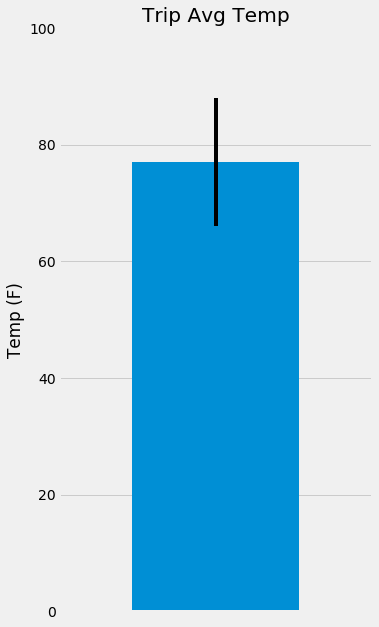

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x= [0]
y=results[1]
yerr=results[2]-results[0]
plt.figure(figsize=(5,10))
plt.bar(x,y,yerr=yerr)
plt.xlim(-0.75,0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0,100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(axis='x',linestyle='')
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

startdate='2016-10-17'
enddate='2016-10-24'

sel=[Station.station,Station.name,Station.latitude,Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

query_results=session.query(*sel).\
            filter(Station.station == Measurement.station).\
            group_by(Measurement.station).\
            filter(Measurement.date>=startdate).\
            filter(Measurement.date<=enddate).\
            order_by(func.sum(Measurement.prcp).desc()).all()

stations=pd.DataFrame(query_results, columns=['Station','Name','Lat','Lng', 'Elevation', 'Total Precip'])
stations

,Station,Name,Lat,Lng,Elevation,Total Precip
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.26
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.40
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.39
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.22
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.14
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.08
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
startdate='2016-10-17'
enddate='2016-10-24'
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Lop through the list of %m-%d strings and calculate the normals for each date
now=dt.datetime.strptime(startdate,'%Y-%m-%d')
enddate=dt.datetime.strptime(enddate,'%Y-%m-%d')

tripdates=[]
while(now<=enddate):
    tripdates.append(now)
    now = now +  dt.timedelta(days=1)
tripdates
normals=[(daily_normals(date.strftime('%m-%d'))) for date in tripdates]
normals
normals=[item for sublist in normals for item in sublist]
normals

[(65.0, 75.07843137254902, 83.0),
 (65.0, 75.0, 83.0),
 (65.0, 73.24489795918367, 81.0),
 (67.0, 74.79629629629629, 82.0),
 (66.0, 74.96078431372548, 82.0),
 (66.0, 74.84313725490196, 81.0),
 (66.0, 75.74468085106383, 84.0),
 (69.0, 74.98039215686275, 81.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
history_df= pd.DataFrame(normals,columns=['tmin','tavg','tmax'],index=tripdates)
history_df.index.name='date'
history_df

,tmin,tavg,tmax
date,,,
2016-10-17,65.0,75.078431,83.0
2016-10-18,65.0,75.000000,83.0
2016-10-19,65.0,73.244898,81.0
2016-10-20,67.0,74.796296,82.0
2016-10-21,66.0,74.960784,82.0
2016-10-22,66.0,74.843137,81.0
2016-10-23,66.0,75.744681,84.0
2016-10-24,69.0,74.980392,81.0


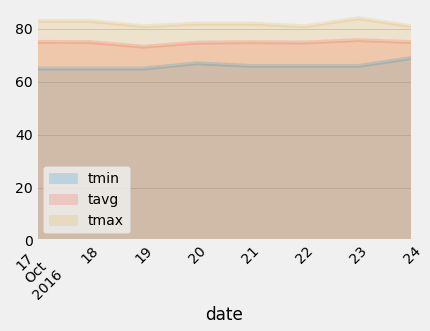

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
history_df.plot(kind='area',stacked=False,rot=45,alpha=.2)